In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor


sns.set_style("whitegrid")

In [45]:
bikes = pd.read_csv('hour.csv', encoding='latin1')

bikes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [12]:
bikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Features:

1. `dteday`  date
2. `season` season (1: winter, 2: spring, 3: summer, 4: fall)
3. `yr` year (0: 2011, 1: 2012)
4. `mnth` month (1 to 12)
5. `hr` hour (0 to 23)
6. `holiday`  whether the day is holiday or not
7. `weekday` day of the week
8. `workingday` if workingday, 1; otherwise 0
9. `weathersit` 

    `1`: Clear, Few clouds, Partly cloudy, Partly cloudy

    `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

    `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

    `4`: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
10. `temp` normalized temperature in Celsius
11. `atemp` "feels like" temperature
12. `hum` normalized humidity 
13. `windspeed` normalized wind speed



Features used for Seoul Bike Data:

hour, temp, humidity, windspeed, visibility, dewpointtemp, UV strength, rainfall, snowfall, season, holiday, functioning day, week day (working day), day of week.


-----

Since the main purpose of this task is to run the algorithms for comparison, we are dropping the month & year columns. 

In [46]:
# rename cols & some cleanup

bikes.rename(columns={'dteday':'date','hum':'humidity','cnt':'bike_count', 'weathersit':'rainfall', 'weekday':'day_of_week', 'workingday':'weekday'}, inplace=True)

bikes['season']=bikes.season.map({1:'spring', 2:'summer',3:'fall', 4:'winter'})
bikes['rainfall']=bikes.rainfall.map({1:0 ,2:0 ,3:1, 4:1})
bikes['day_of_week']=bikes.day_of_week.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

bikes.head()


,instant,date,season,yr,mnth,hr,holiday,day_of_week,weekday,rainfall,temp,atemp,humidity,windspeed,casual,registered,bike_count
0,1,2011-01-01,spring,0,1,0,0,Sat,0,0,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,spring,0,1,1,0,Sat,0,0,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,spring,0,1,2,0,Sat,0,0,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,spring,0,1,3,0,Sat,0,0,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,spring,0,1,4,0,Sat,0,0,0.24,0.2879,0.75,0.0,0,1,1


In [47]:
# dropping index, year, month, casual, registered (as we only looked at total bike counds for Seoul data)

bikes = bikes.drop(['instant', 'yr','mnth','casual','registered'], axis=1)


# EDA

In [ ]:
bikes.sample(5)

,date,season,hr,holiday,day_of_week,weekday,rainfall,temp,atemp,humidity,windspeed,bike_count
14178,2012-08-18,fall,23,0,Sat,0,0,0.64,0.6061,0.65,0.0896,235
15692,2012-10-21,winter,1,0,Sun,0,0,0.42,0.4242,0.58,0.2239,117
8702,2012-01-03,spring,10,0,Tue,1,0,0.16,0.1212,0.47,0.4627,60
518,2011-01-23,spring,17,0,Sun,0,0,0.14,0.1061,0.26,0.3881,55
4188,2011-06-28,fall,10,0,Tue,1,0,0.80,0.7424,0.49,0.1642,157


In [ ]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         17379 non-null  object 
 1   season       17379 non-null  object 
 2   hr           17379 non-null  int64  
 3   holiday      17379 non-null  int64  
 4   day_of_week  17379 non-null  object 
 5   weekday      17379 non-null  int64  
 6   rainfall     17379 non-null  int64  
 7   temp         17379 non-null  float64
 8   atemp        17379 non-null  float64
 9   humidity     17379 non-null  float64
 10  windspeed    17379 non-null  float64
 11  bike_count   17379 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 1.6+ MB


In [16]:
continuous_features = ['hr', 'temp', 'atemp', 'humidity', 'windspeed']
categorical_features = ['season', 'holiday', 'weekday', 'day_of_week', 'rainfall']

all_features = continuous_features + categorical_features


In [17]:
bikes_train, bikes_test = train_test_split(bikes.copy(),
                                           test_size = 0.2,
                                           random_state=2023,
                                           shuffle=True)

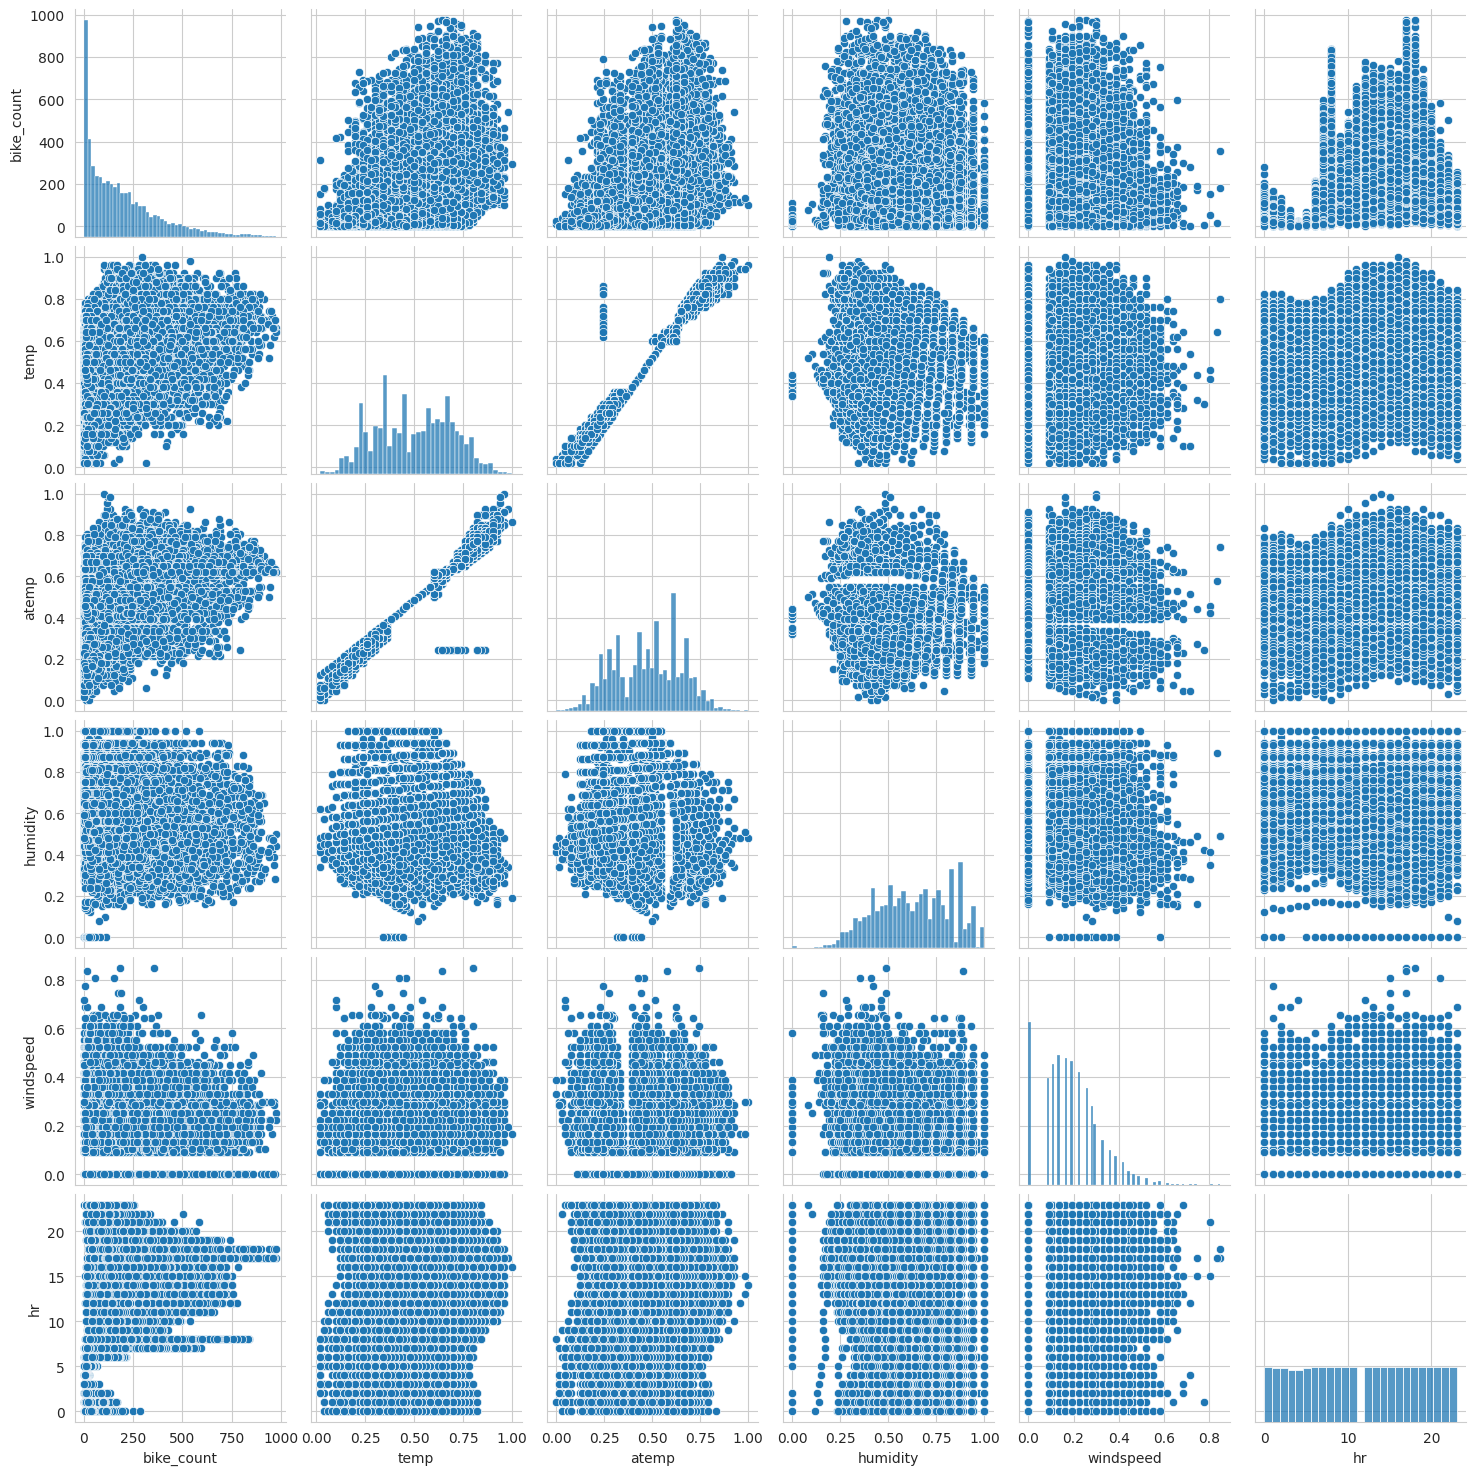

In [ ]:
#pairplot for numeric variables
sns.pairplot(bikes,
             vars = ['bike_count','temp','atemp', "humidity",'windspeed','hr'])
plt.show()

It appears that temperature significantly affects bike count.

On the other hand, windspread & humidity do not seem to have much significance.

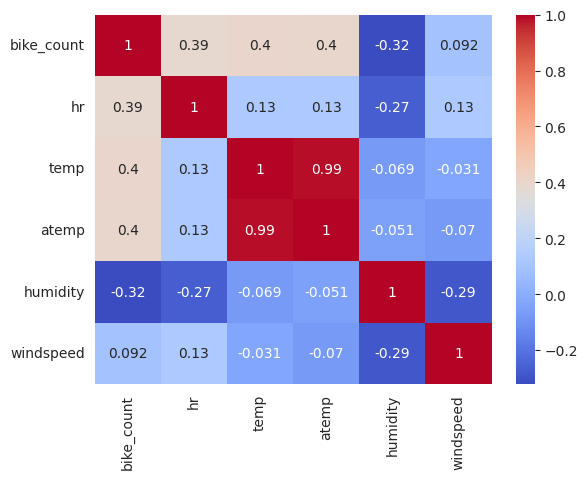

In [ ]:
# Calculate correlation matrix
correlation_matrix = bikes_train[['bike_count'] + continuous_features].corr()

# Create correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Display the plot
plt.show()

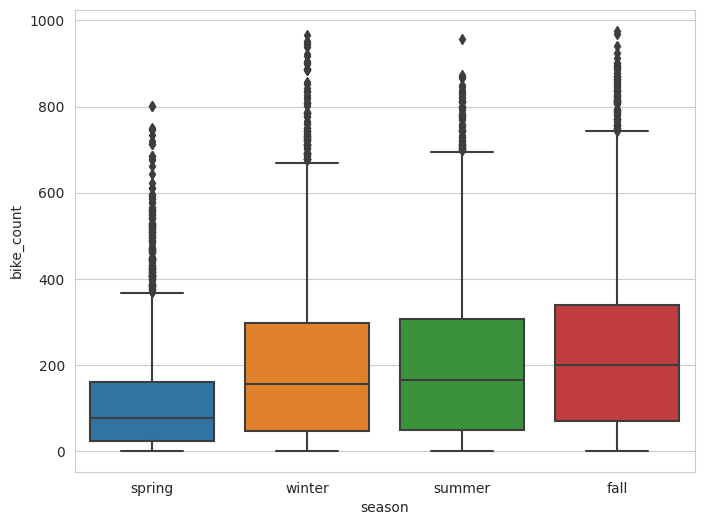

In [ ]:
# Boxplot for season:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'season')

plt.xlabel('season')
plt.ylabel('bike_count')

plt.show()

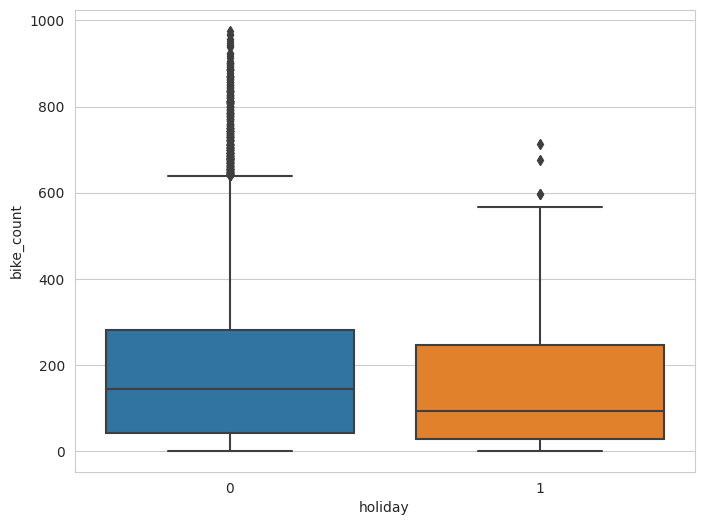

In [ ]:
# Boxplot for holiday:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'holiday')

plt.xlabel('holiday')
plt.ylabel('bike_count')

plt.show()

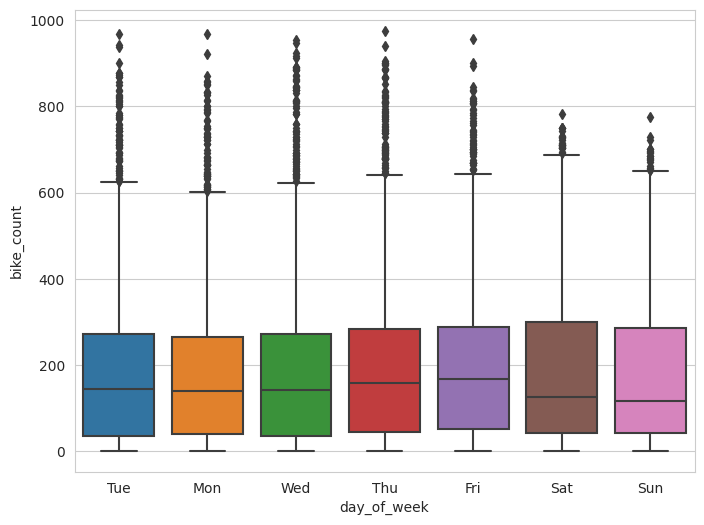

In [ ]:
# Boxplot for day_of_week:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'day_of_week')

plt.xlabel('day_of_week')
plt.ylabel('bike_count')

plt.show()

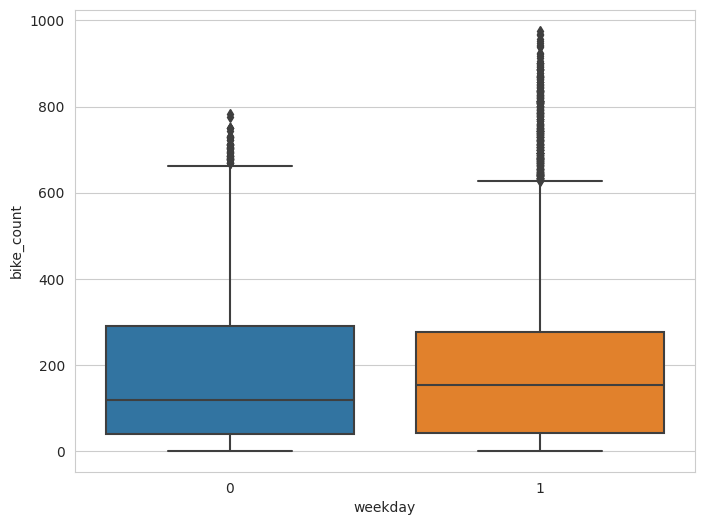

In [ ]:
# Boxplot for weekday:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'weekday')

plt.xlabel('weekday')
plt.ylabel('bike_count')

plt.show()

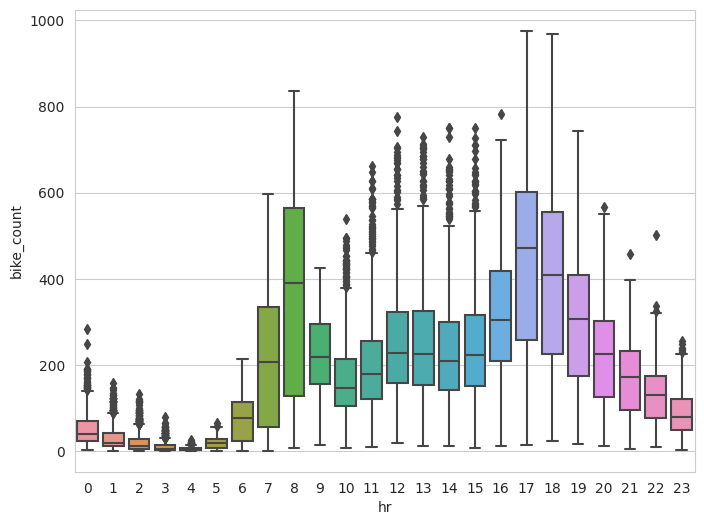

In [ ]:
# Boxplot for hours

# peak at morning rush hours & evening (8am, 5pm and after)

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'hr')

plt.xlabel('hr')
plt.ylabel('bike_count')

plt.show()

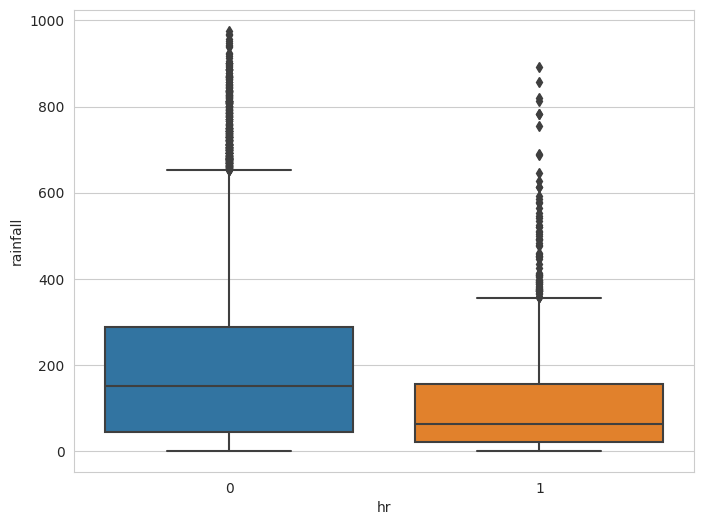

In [ ]:
# Boxplot for rainfall

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'rainfall')

plt.xlabel('hr')
plt.ylabel('rainfall')

plt.show()

Not much signifance for holiday, day of week, and weekdays.

Appears that rainfall, hr, & season do have sigificance

In [ ]:
# Importance of features using permutation_importance (see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) 

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
numerical_pipe = StandardScaler() 

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("num", numerical_pipe, continuous_features),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(#max_depth=5, 
                                             #max_samples=80, 
                                             #n_estimators=1000,
                                             random_state=614)),
    ]
)
rf.fit(bikes_train.drop(["date", "bike_count"], axis=1),
       bikes_train['bike_count'])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['season', 'holiday',
                                                   'weekday', 'day_of_week',
                                                   'rainfall']),
                                                 ('num', StandardScaler(),
                                                  ['hr', 'temp', 'atemp',
                                                   'humidity', 'windspeed'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestRegressor(random_state=614))])

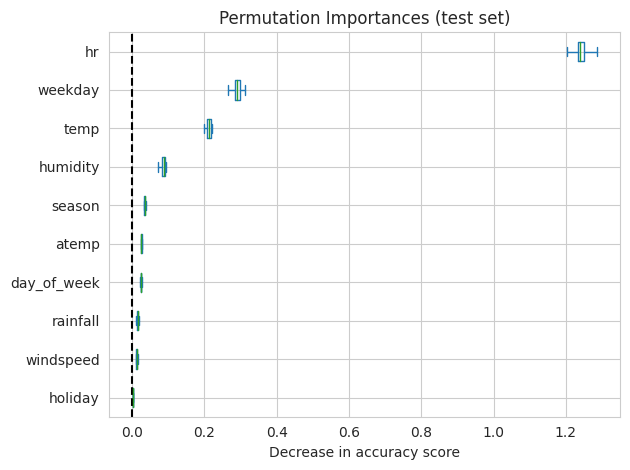

In [ ]:
result = permutation_importance(
    rf, 
    bikes_test.drop(["date", "bike_count"], axis=1), 
    bikes_test['bike_count'], 
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=bikes.drop(['date', 'bike_count'], axis=1).columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

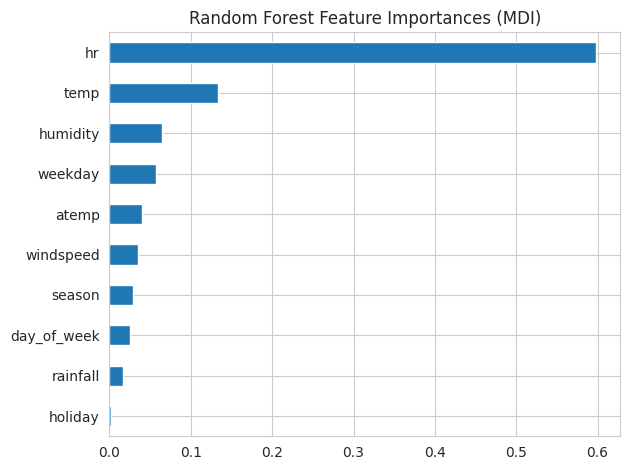

In [ ]:
# Feature Importance from Mean Decrease in Impurity (MDI)
# (from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()


The two most significant features are hr and temp, which is also observed with the Seoul data.

Other features do not seem to have as much significance.


Again, since the main purpose is to compare the analysis with the Seoul data (which considered all possible features), we are not reducing any additional features.

# Model Training

We try the following models:



*   Histogram-based Gradient Boosting Regression
*   XGBoosting Regression
*   Extra Trees Regression
*   Random Forest Regression
*   Support Vector Regression
*   KNN Regression
*   Voter Model

We tune hyperparameters for each model using GridSearchCV; see https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_grid_search.html





In [18]:
# We use all features (we tried reducing the number of features, but the results weren't better)

chosen_continuous_features = ['hr', 'temp', 'atemp', 'humidity','windspeed']
chosen_categorical_features = ['season', 'holiday','weekday', 'day_of_week','rainfall'] 
chosen_features = chosen_continuous_features + chosen_categorical_features


In [19]:
bikes_train[chosen_features]

,hr,temp,atemp,humidity,windspeed,season,holiday,weekday,day_of_week,rainfall
9884,21,0.34,0.3333,0.61,0.1642,spring,0,1,Tue,0
1007,15,0.56,0.5303,0.21,0.6567,spring,0,1,Mon,0
6719,13,0.54,0.5152,0.88,0.2239,winter,0,1,Wed,1
11260,9,0.46,0.4545,0.72,0.0000,summer,0,1,Thu,0
7259,2,0.40,0.4091,0.76,0.0000,winter,0,1,Fri,0
...,...,...,...,...,...,...,...,...,...,...
470,15,0.16,0.1212,0.26,0.4478,spring,0,1,Fri,0
6659,1,0.48,0.4697,0.88,0.0000,winter,1,0,Mon,0
5852,8,0.54,0.5152,0.83,0.3881,fall,0,1,Tue,1
6049,15,0.78,0.7121,0.49,0.2537,fall,0,1,Wed,0


In [20]:
# Some pre-processing (relevant source: https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_grid_search.html)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

continuous_preprocessor = StandardScaler() 

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, chosen_categorical_features),
    ('cont_preprocessor', continuous_preprocessor, chosen_continuous_features)],
    remainder='passthrough', sparse_threshold=0)



## Histogram-based Gradient Boosting Regression




In [28]:
HGB = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor",
     HistGradientBoostingRegressor(random_state=42))])

# We will run grid search in several rounds. First run Round 1, then define the Round 2 param_grid depending on the results of Round 1, run round 2, etc.

# Round 1
param_grid_1 = {
    'regressor__learning_rate': [0.01, 0.1, 1, 10],
    'regressor__max_leaf_nodes': [45, 55, 60, 65, 70, 75, 80, 85],
    'regressor__l2_regularization': [0, 1, 2, 5]}

# Output: 
# best parameters for HGB: {'regressor__l2_regularization': 5, 'regressor__learning_rate': 0.1, 'regressor__max_leaf_nodes': 80}
# negative MSE score for HGB: -4505.703204255402


# Round 2
param_grid_2 = {
    'regressor__learning_rate': [0.05, 0.1, 0.15],
    'regressor__max_leaf_nodes': [78, 79, 80, 81, 82],
    'regressor__l2_regularization': [4, 5, 6]}

# Output:
# best parameters for HGB: {'regressor__l2_regularization': 5, 'regressor__learning_rate': 0.15, 'regressor__max_leaf_nodes': 79}
# negative MSE score for HGB: -4504.597801546513
# Not much different from above, so let's stop here

HGB_grid_search = GridSearchCV(HGB, 
                               param_grid=param_grid_2,
                               scoring = 'neg_mean_squared_error',
                               n_jobs=2, 
                               cv=5)

HGB_grid_search.fit(bikes_train[chosen_features],
       bikes_train['bike_count'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'day_of_week',
                                                                          'rainfall']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hr',
                                                                          'temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed'])])),
                                       ('regressor',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=2,
             param_grid={'regressor__l2_regularization': [4, 5, 6],
                         'regressor__learning_rate': [0.05, 0.1, 0.15],
                         'regressor__max_leaf_nodes': [78, 79, 80, 81, 82]},
             scoring='neg_mean_squared_error')

In [29]:
print('best parameters for HGB: ' + str(HGB_grid_search.best_params_))
print('negative MSE score for HGB: ' + str(HGB_grid_search.best_score_))

best parameters for HGB: {'regressor__l2_regularization': 5, 'regressor__learning_rate': 0.15, 'regressor__max_leaf_nodes': 79}
negative MSE score for HGB: -4504.597801546513


## XGBoost Regression


In [26]:
XGB = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, 
                               tree_method='hist', 
                               subsample=0.7, # only use a random subset consisting of 70% of the data (may help prevent overfitting and speed up the process)
                               colsample_bytree=0.6, # only use a random 60% subset of features per tree (may help prevent overfitting and speed up the process)
    )
    )
])

# We implement grid search in several rounds (because the process takes a long time). First run Round 1, then define the Round 2 param_grid depending on the results of Round 1, run round 2, etc.

# Round 1
param_grid_1 = {
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [8, 10],
    'regressor__n_estimators': [500, 1000],
    'regressor__gamma': [0.5, 1],
    'regressor__reg_lambda': [2, 5]
}
# Round 1 output: 
# best parameters for XGB: {'regressor__gamma': 0.5, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__n_estimators': 1000, 'regressor__reg_lambda': 5}
# negative MSE score for XGB: -4488.709502262326

# Round 2
param_grid_2 = {
    'regressor__learning_rate': [0.005, 0.01, 0.03],
    'regressor__max_depth': [10, 12],
    'regressor__n_estimators': [1000, 1400],
    'regressor__gamma': [0.3, 0.5],
    'regressor__reg_lambda': [5, 10]
}
# Round 2 output: 
# best parameters for XGB: {'regressor__gamma': 0.5, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__n_estimators': 1400, 'regressor__reg_lambda': 10}
# negative MSE score for XGB: -4445.4021332749835

# Round 3
param_grid_3 = {
    'regressor__learning_rate': [0.01],
    'regressor__max_depth': [10],
    'regressor__n_estimators': [1400, 1800],
    'regressor__gamma': [0.4, 0.5, 0.6],
    'regressor__reg_lambda': [10, 15]
}
# Round 3 output: 
# best parameters for XGB: {'regressor__gamma': 0.4, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__n_estimators': 1800, 'regressor__reg_lambda': 15}
# negative MSE score for XGB: -4424.703292492081

# Round 4
param_grid_4 = {
    'regressor__learning_rate': [0.01],
    'regressor__max_depth': [10],
    'regressor__n_estimators': [1800, 2400],
    'regressor__gamma': [0.4, 0.5],
    'regressor__reg_lambda': [15, 20]
}

# Round 4 output:
# best parameters for XGB: {'regressor__gamma': 0.4, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__n_estimators': 1800, 'regressor__reg_lambda': 20}
# negative MSE score for XGB: -4416.091515556127

# No significant improvements, so let's go with the parameters from Round 4 (we could have even stopped after Round 2)

XGB_grid_search = GridSearchCV(XGB, 
                               param_grid=param_grid_4,
                               scoring='neg_mean_squared_error',
                               n_jobs=10,
                               verbose=True,
                               cv=3) # I only used 3-fold cross-validation to speed up the process (but even with cv=3 it takes long)

XGB_grid_search.fit(bikes_train[chosen_features], bikes_train['bike_count'])


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'day_of_week',
                                                                          'rainfall']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hr',
                                                                          'temp',
                                                                          'atemp',
                                                                          'humidity',...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=10,
             param_grid={'regressor__gamma': [0.4, 0.5],
                         'regressor__learning_rate': [0.01],
                         'regressor__max_depth': [10],
                         'regressor__n_estimators': [1800, 2400],
                         'regressor__reg_lambda': [15, 20]},
             scoring='neg_mean_squared_error', verbose=True)

In [27]:
print('best parameters for XGB: ' + str(XGB_grid_search.best_params_))
print('negative MSE score for XGB: ' + str(XGB_grid_search.best_score_))

best parameters for XGB: {'regressor__gamma': 0.4, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__n_estimators': 1800, 'regressor__reg_lambda': 20}
negative MSE score for XGB: -4416.091515556127


## Extra Trees Regression


In [30]:
ET = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor",
     ExtraTreesRegressor(random_state=42))])


# Round 1
param_grid_1 = {
    'regressor__max_depth': [20, 22, 24], 
    'regressor__n_estimators': [1000, 1200, 1400], 
    }
# Round 1 output:
# best parameters for ET: {'regressor__max_depth': 20, 'regressor__n_estimators': 1000}
# negative MSE score for ET: -5145.573969092039

# Round 2
param_grid_2 = {
    'regressor__max_depth': [16, 18, 20], 
    'regressor__n_estimators': [800, 1000], 
    }
# Round 2 output:
# best parameters for ET: {'regressor__max_depth': 16, 'regressor__n_estimators': 1000}
# negative MSE score for ET: -4934.636859302425

# Round 3
param_grid_3 = {
    'regressor__max_depth': [14, 16, 18], 
    'regressor__n_estimators': [800, 1000, 1200], 
    }
# Round 3 output:
# best parameters for ET: {'regressor__max_depth': 14, 'regressor__n_estimators': 1000}
# negative MSE score for ET: -4870.432605823914

# Round 4
param_grid_4 = {
    'regressor__max_depth': [12, 14, 16], 
    'regressor__n_estimators': [900, 1000, 1100], 
    }
# Round 4 output:
# best parameters for ET: {'regressor__max_depth': 14, 'regressor__n_estimators': 900}
# negative MSE score for ET: -4870.021517898179

# No significant improvements after Round 4

ET_grid_search = GridSearchCV(ET, 
                               param_grid=param_grid_4,
                               scoring = 'neg_mean_squared_error',
                               n_jobs=5, 
                               verbose = True,
                               cv=5)

ET_grid_search.fit(bikes_train[chosen_features],
       bikes_train['bike_count'])



Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'day_of_week',
                                                                          'rainfall']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hr',
                                                                          'temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed'])])),
                                       ('regressor',
                                        ExtraTreesRegressor(random_state=42))]),
             n_jobs=5,
             param_grid={'regressor__max_depth': [12, 14, 16],
                         'regressor__n_estimators': [900, 1000, 1100]},
             scoring='neg_mean_squared_error', verbose=True)

In [31]:
print('best parameters for ET: ' + str(ET_grid_search.best_params_))
print('negative MSE score for ET: ' + str(ET_grid_search.best_score_))

best parameters for ET: {'regressor__max_depth': 14, 'regressor__n_estimators': 900}
negative MSE score for ET: -4870.021517898179


## Random Forest Regression

In [32]:
RF = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor",
     RandomForestRegressor(random_state=42))])

# Here I also did several rounds of grid search, but I'm skipping the details

param_grid = {
    'regressor__max_depth': [14, 16, 18], 
    'regressor__n_estimators': [100, 200, 400]
    }

RF_grid_search = GridSearchCV(RF, 
                               param_grid=param_grid,
                               scoring = 'neg_mean_squared_error',
                               n_jobs=5, 
                               verbose = True,
                               cv=5)

RF_grid_search.fit(bikes_train[chosen_features],
       bikes_train['bike_count'])


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'day_of_week',
                                                                          'rainfall']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hr',
                                                                          'temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=5,
             param_grid={'regressor__max_depth': [14, 16, 18],
                         'regressor__n_estimators': [100, 200, 400]},
             scoring='neg_mean_squared_error', verbose=True)

In [33]:
print('best parameters for RF: ' + str(RF_grid_search.best_params_))
print('negative MSE score for RF: ' + str(RF_grid_search.best_score_))

best parameters for RF: {'regressor__max_depth': 16, 'regressor__n_estimators': 200}
negative MSE score for RF: -4935.023982375492


## Support Vector Regression

In [36]:
SVR = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", SVR())
])

# Here I also did several rounds of grid search, but I'm skipping the details

param_grid = {
    'regressor__C': [80, 100],  # Penalty parameter C
    'regressor__kernel': ['linear', 'rbf'],  # Kernel function
    'regressor__gamma': ['scale', 'auto'],  # Kernel coefficient 
    'regressor__epsilon': [0.2, 0.3, 0.4]  # Epsilon in the epsilon-insensitive loss function
}

SVR_grid_search = GridSearchCV(SVR,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               n_jobs=5,
                               cv=5,
                               verbose = True)

SVR_grid_search.fit(bikes_train[chosen_features], bikes_train['bike_count'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'day_of_week',
                                                                          'rainfall']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hr',
                                                                          'temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed'])])),
                                       ('regressor', SVR())]),
             n_jobs=5,
             param_grid={'regressor__C': [80, 100],
                         'regressor__epsilon': [0.2, 0.3, 0.4],
                         'regressor__gamma': ['scale', 'auto'],
                         'regressor__kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error', verbose=True)

In [37]:
print('best parameters for SVR: ' + str(SVR_grid_search.best_params_))
print('negative MSE score for SVR: ' + str(SVR_grid_search.best_score_))

best parameters for SVR: {'regressor__C': 100, 'regressor__epsilon': 0.2, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
negative MSE score for SVR: -15751.005592820069


## KNeighbors Regression

In [34]:
KNN = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", KNeighborsRegressor())
])

param_grid = {
    'regressor__n_neighbors': list(range(1, 20, 1)),
    'regressor__weights': ['uniform', 'distance']
}

KNN_grid_search = GridSearchCV(KNN, 
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               n_jobs=2, 
                               cv=5)

KNN_grid_search.fit(bikes_train[chosen_features],
                    bikes_train['bike_count'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'day_of_week',
                                                                          'rainfall']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hr',
                                                                          'temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed'])])),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=2,
             param_grid={'regressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19],
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [35]:
print('best parameters for KNN: ' + str(KNN_grid_search.best_params_))
print('negative MSE score for KNN: ' + str(KNN_grid_search.best_score_))

best parameters for KNN: {'regressor__n_neighbors': 6, 'regressor__weights': 'distance'}
negative MSE score for KNN: -11944.842672203853


## Voting Regression and model selection



In [38]:
# Split the training set further to get a validation set

bikes_tt, bikes_val = train_test_split(bikes_train,
                              shuffle=True,
                              random_state=3222,
                              test_size=0.2)

In [39]:
# Define the regressors with the hyperparameters chosen by the grid searches above
HGB_regressor = HGB_grid_search.best_estimator_['regressor']
XGB_regressor = XGB_grid_search.best_estimator_['regressor']
RF_regressor = RF_grid_search.best_estimator_['regressor']
ET_regressor = ET_grid_search.best_estimator_['regressor']
SVR_regressor = SVR_grid_search.best_estimator_['regressor']
KNN_regressor = KNN_grid_search.best_estimator_['regressor']


# Create the Voting Regressor
vote_regressor = VotingRegressor(
    estimators=[
        ('hgb', HGB_regressor), 
        ('xgb', XGB_regressor),
        ('rf', RF_regressor),
        ('et', ET_regressor),
     #   ('svr', SVR_regressor), I left out SVR because it makes the voter model worse
     #   ('knn', KNN_regressor)  I left out KNN because it makes the voter model worse
         ],
)

# Create the pipeline with the preprocessor and the Voting Regressor
vote_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", vote_regressor)
])

# Pipeline with HGB_regressor
hgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", HGB_regressor)
])

# Pipeline with XGB_regressor:
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGB_regressor)
])

# Pipeline with ET_regressor:
et_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ET_regressor)
])

# Pipeline with RF_regressor:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RF_regressor)
])

# Pipeline with SVR_regressor:
svr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", SVR_regressor)
])

# Pipeline with KNN_regressor:
knn_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", KNN_regressor)
])






In [40]:
# Fit the pipelines to the training data
vote_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
hgb_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
xgb_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
et_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
rf_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
svr_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
knn_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['season', 'holiday',
                                                   'weekday', 'day_of_week',
                                                   'rainfall']),
                                                 ('cont_preprocessor',
                                                  StandardScaler(),
                                                  ['hr', 'temp', 'atemp',
                                                   'humidity',
                                                   'windspeed'])])),
                ('regressor',
                 KNeighborsRegressor(n_neighbors=6, weights='distance'))])

In [41]:
# Get predictions on the validation set
vote_pred = vote_pipeline.predict(bikes_val[chosen_features])
hgb_pred = hgb_pipeline.predict(bikes_val[chosen_features])
xgb_pred = xgb_pipeline.predict(bikes_val[chosen_features])
et_pred = et_pipeline.predict(bikes_val[chosen_features])
rf_pred = rf_pipeline.predict(bikes_val[chosen_features])
svr_pred = svr_pipeline.predict(bikes_val[chosen_features])
knn_pred = knn_pipeline.predict(bikes_val[chosen_features])



In [42]:
vote_mse = mean_squared_error(bikes_val['bike_count'], vote_pred)
hgb_mse = mean_squared_error(bikes_val['bike_count'], hgb_pred)
xgb_mse = mean_squared_error(bikes_val['bike_count'], xgb_pred)
et_mse = mean_squared_error(bikes_val['bike_count'], et_pred)
rf_mse = mean_squared_error(bikes_val['bike_count'], rf_pred)
svr_mse = mean_squared_error(bikes_val['bike_count'], svr_pred)
knn_mse = mean_squared_error(bikes_val['bike_count'], knn_pred)

# Create a DataFrame
mse_df = pd.DataFrame({
    'Regressor': ['Voter', 'HGB', 'XGB', 'ET', 'RF', 'SVR', 'KNN'],
    'MSE': [vote_mse, hgb_mse, xgb_mse, et_mse, rf_mse, svr_mse, knn_mse]
})

# Sort the DataFrame by MSE in ascending order
mse_df = mse_df.sort_values(by='MSE', ascending=True)

In [43]:
print('MSEs on the validation set:')
print()
mse_df

MSEs on the validation set:



,Regressor,MSE
2,XGB,4498.446241
1,HGB,4690.298763
0,Voter,4696.552088
3,ET,5195.108605
4,RF,5291.292368
6,KNN,12478.160786
5,SVR,16798.227407


In [44]:
# Fitting the best three models: XGB, Voter, HGB

# XGBoost
xgb_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
xgb_predict = xgb_pipeline.predict(bikes_test[chosen_features])
print('MSE of XGB on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], xgb_predict)))

# Voter
vote_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
vote_predict = vote_pipeline.predict(bikes_test[chosen_features])
print('MSE of Voter on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], vote_predict)))

# HGBoost
hgb_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
hgb_predict = hgb_pipeline.predict(bikes_test[chosen_features])
print('MSE of HGB on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], hgb_predict)))



MSE of XGB on the entire testing set: 4265.780799091904
MSE of Voter on the entire testing set: 4447.998083074991
MSE of HGB on the entire testing set: 4483.082612993278


All models seem to overfit a little bit.

Compared to the Seoul Bike data, these models actually work better with the DC data than Seoul.
